<span style="font-family:Papyrus; font-size:3em;">Computational Experiments</span>

<span style="font-family:Papyrus; font-size:2em;">Two Factors in Combination (TFC) Design</span>

This lecture continues the analysis of the Wolf model of glycolytic oscillations to consider the effects of two parameters in combination.

# Programming Preliminaries

In [1]:
IS_COLAB = False

In [2]:
# Code installs. Only needed once.
if IS_COLAB:
    !pip install matplotlib
    !pip install numpy
    !pip install pandas
    !pip install scipy
    !pip install tellurium
    !pip install seaborn

In [3]:
# Constants for standalone notebook
if not IS_COLAB:
    DIR = "/home/ubuntu/advancing-biomedical-models/common"  # Insert your local directory path
else:
    from google.colab import drive
    drive.mount('/content/drive')
    DIR = "/content/drive/MyDrive/Winter 2021/common"
import sys
sys.path.insert(0, DIR)

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy import fftpack
import tellurium as te
import seaborn as sns
import util_doe1  # Various functions from lecture 5
import wolf_model as wm

# Design

A TFC design is used to identify interactions between factors.
This means that there is an experiment for every combination of levels of both factors.
That is, there are $n_1 \times n_2$ experiments if there are $n_i$ levels of the two factors.

## Challenge: Reducing combinatorics

A first challenge with a TFC is the number of constants that must be estimated.
For example, the Wolf model has 16 parameters, which means that there are 120 interactions, each of which need to be calculated at several levels.
With 10 levels for each interaction, this results in $10 \times 10 \times 120 = 12,000$ constants to calculate.

### Question
1. What are some approaches to reducing the number of constants to estimate in a TFC design?
1. What interaction terms should be estimated for the Wolf model?

## Challenge: Visualization

### Question
1. How should we present the responses that clearly presents which interaction terms are displayed, their values, and patterns in the responses?

# Generalize runExperiments
Generalize ``runExperiments`` so that it calculates responses for all combinations of levels of two parameters.

In [5]:
def runExperimentsTwoParameters(parameter1, parameter2, percent1s, percent2s, isRelative=True):
    """
    Runs experiments for changes in multipleparameters of the model at different percent changes in the parameter value (levels).
    
    Parameter
    ---------
    parameter1: str
    parameter2: str
    percent1s: list-int
    percent2s: list-int
    isRelative: bool
        True: values are percent changes relative to baseline
        False: absolute value
        
    Returns
    -------
    frequencyDF: DataFrame, amplitude: DataFrame
       index: tuple of percent changes in parameter values
       columns: molecule
       value: depends on isRelative
       index.name: string of tuple (rowParameter, columnParameter)
    """
    INDEX1 = "index1"
    INDEX2 = "index2"
    # Calculate the baseline values
    baseFrequencySer, baseAmplitudeSer = util_doe1.runExperiment({})
    #
    def calcResponseSer(ser, isFrequency=True):
        """
        Calculates the relative response.
        
        Parameters
        ----------
        ser: pd.Series
            index: molecule
            value: absolute respoinse
        isFrequency: bool
            if True, frequency response; else, amplitude response
                         
        Returns
        -------
        pd.Series
        """
        if not isRelative:
            return ser
        if isFrequency:
            baseSer = baseFrequencySer
        else:
            baseSer = baseAmplitudeSer
        resultSer = 100*(ser - baseSer)/baseSer
        return resultSer
    #
    def calcLevelDF(isFrequency=None):
        """
        Calculates the dataframe of levels dataframe.
        
        Parameter
        --------
        isFrequency: bool
            If True, frequency response. Otherwise, amplitude response
            
        Returns
        -------
        pd.DataFrame
            index: tuple-int
                levels of parameters
            columns: str
                molecule
            values: response
        """
        if isFrequency is None:
            raise ValueError("Must specify isFrequency!")
        sers = []  # Collection of experiment results
        index1 = []
        index2 = []
        for percent1 in percent1s:
            for percent2 in percent2s:
                #indices.append("%d_%d" % (percent1, percent2))
                index1.append(percent1)
                index2.append(percent2)
                parameterDct = {parameter1: percent1, parameter2: percent2}
                frequencySer, amplitudeSer = util_doe1.runExperiment(parameterDct)
                if isFrequency:
                    ser = frequencySer
                else:
                    ser = amplitudeSer
                adjSer = calcResponseSer(ser, isFrequency=isFrequency)
                sers.append(pd.DataFrame(adjSer).transpose())
        resultDF = pd.concat(sers)
        resultDF[INDEX1] = index1
        resultDF[INDEX2] = index2
        resultDF = resultDF.set_index([index1, index2])
        for column in [INDEX1, INDEX2]:
            del resultDF[column]
        resultDF.index.name = str((parameter1, parameter2))
        return resultDF
    #
    frequencyDF = calcLevelDF(isFrequency=True)
    amplitudeDF = calcLevelDF(isFrequency=False)
    return frequencyDF, amplitudeDF

# Tests
percents = [-7, -5, -2, 0, 2, 5, 7]
fDF, aDF = runExperimentsTwoParameters("J1_Ki", "J1_k1", percents, percents)
assert(aDF.loc[(percents[-1], percents[-1]), "Glucose"] < 0 )
assert(fDF.loc[(percents[0], percents[0]), "Glucose"] < 0 )

In [6]:
# Test Data
TEST_FDF = fDF
TEST_ADF = aDF

## Question
1. Display the amplitude response if there is no change in either J1_Ki or J1_k1.
1. Display the amplitude responses for J1_Ki is 0% and all changes in J1_k1.

## Solution

In [7]:
# Solution 1
print("** Solution to 1:\n")
print(aDF.loc[(0,0), :])

# Solution 2
indices = [(0, p) for p in percents]
print("\n\n** Solution to 2:\n")
print(aDF.loc[indices, :])

** Solution to 1:

Glucose                       0.0
fructose_1_6_bisphosphate     0.0
glyceraldehyde_3_phosphate    0.0
glycerate_3_phosphate         0.0
pyruvate                      0.0
Acetyladehyde                 0.0
External_acetaldehyde         0.0
ATP                           0.0
ADP                           0.0
NAD                           0.0
NADH                          0.0
Name: (0, 0), dtype: float64


** Solution to 2:

        Glucose  fructose_1_6_bisphosphate  glyceraldehyde_3_phosphate  \
0 -7   4.095163                   3.969873                    5.987780   
  -5 -16.194219                 -16.195092                  -16.874792   
  -2 -10.167903                 -10.958226                  -10.307399   
   0   0.000000                   0.000000                    0.000000   
   2  -1.490985                  -0.508779                   -2.969398   
   5 -24.531760                 -22.903761                  -26.759622   
   7 -31.378887                 -31.092

# Visualizing results of an Experiment

We will visualize the TFC reponses using a heatmap. The horizontal and vertical axes
will be percent changes in parameter values; cells will be colored with the change in magnitude.

## Example of a heatmap in python

The example below generates a heatmap from a pandas DataFrame. 
The horizontal axis are the column names; the vertical axis are the values of the index of the DataFrame.
Values are encoded as a heat representation from 0 to 1.0.

In [8]:
# DataFrame
df = pd.DataFrame({"a": np.random.random(5), "b": np.random.random(5)})
df.index = [10*v for v in range(len(df))]
df

,a,b
0,0.517597,0.874638
10,0.715792,0.384215
20,0.869845,0.528042
30,0.170253,0.408802
40,0.134467,0.599785


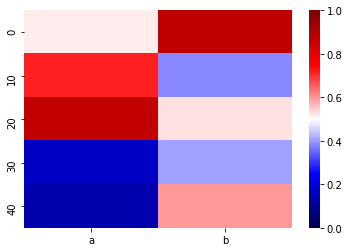

In [9]:
# Generating the heatmap
_ = sns.heatmap(df, cmap='seismic', vmin=0, vmax=1)

## Heat map for two parameters in combination

### Question
1. Generate a heatmap for the results of experiments varying the parameters "J1_k1" and "J1_Ki" in combination
for levels -10, -5, 0, 5, 10.
The names of molecules should be the rows.

### Solution

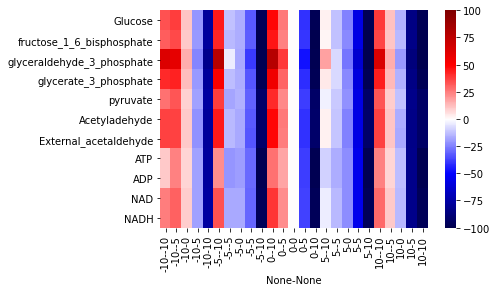

In [10]:
percents = [-10, -5, 0, 5, 10]
fDF, aDF = runExperimentsTwoParameters("J1_k1", "J1_Ki", percents, percents)
_ = sns.heatmap(aDF.transpose(), cmap='seismic', vmin=-100, vmax=100)

### Question
1. Create a function that transforms the frequency (or amplitude) DataFrame so that rows are values of parameter 1, columns are values of parameter 2,
and cells are values of a designated molecule.

### Solution

In [11]:
def pivotResponse(responseDF, molecule):
    """
    Creates a DataFrame in which values of the parameters are rows and columns.
    
    Parameters
    ----------
    responseDF: DataFrame
        columns: molecule names
        rows: tuple of percent changes in parameters
        values: response
        index.name: string of tuple (rowParameter, columnParameter)
    molecule: str
        
    Returns
    -------
    DataFrame
        columns: values of columnParameter
        rows: values of rowParameter
        cells: response for molecule
    """
    LEVEL0 = "level_0"
    LEVEL1 = "level_1"
    df = responseDF.reset_index()
    resultDF = pd.pivot_table(df, values=molecule, index=LEVEL0, columns=LEVEL1)
    parameters = eval(responseDF.index.name)
    resultDF.index.name = parameters[0]
    resultDF.columns.name = parameters[1]
    return resultDF

# Tests
df = pivotResponse(TEST_FDF, "Glucose")
#pd.pivot_table(df, values="Glucose", index="level_0", columns="level_1")
assert(len(df.index) == len(df.columns))

### Question
1. Write a function that constructs a heatmap that displays interaction results for a single molecule (e.g., Glucose) and has rows that are changes to one parameter and columns that are changes to the other parameter. The function should return the axis.

### Solution

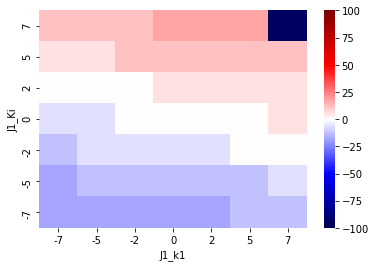

In [12]:
def makeHeatmap(responseDF, molecule, isColorbar=True, ax=None, vmin=-100, vmax=100, cbar_ax=None):
    """
    Creates a heatmap showing the interactions of response values for two parameters.
    
    Parameters
    ----------
    reponseDF: DataFrame
        index: tuples of percent changes in parameter values
        columns: molecule
        values: response
    molecule: str
    isColorbar: bool
        show the colorbar
    vmin: float
        minimum value in color bar
    vmax: float
        maximum value in color bar
    cbar_ax: Axes
    """
    df = pivotResponse(responseDF, molecule)
    df = df.sort_index(ascending=False)  # Show large values on top
    if ax is None:
        ax = sns.heatmap(df, cmap='seismic', vmin=vmin, vmax=vmax, cbar=isColorbar, cbar_ax=cbar_ax)
    else:
        _ = sns.heatmap(df, cmap='seismic', vmin=vmin, vmax=vmax, cbar=isColorbar, ax=ax, cbar_ax=cbar_ax)
    return ax

# Tests
_ = makeHeatmap(TEST_FDF, "ATP")

# Running a Study

## Question
1. Write a function that generates an upper triangular matrix of plots labelled with the interactions between parameter pairs.

## Solution

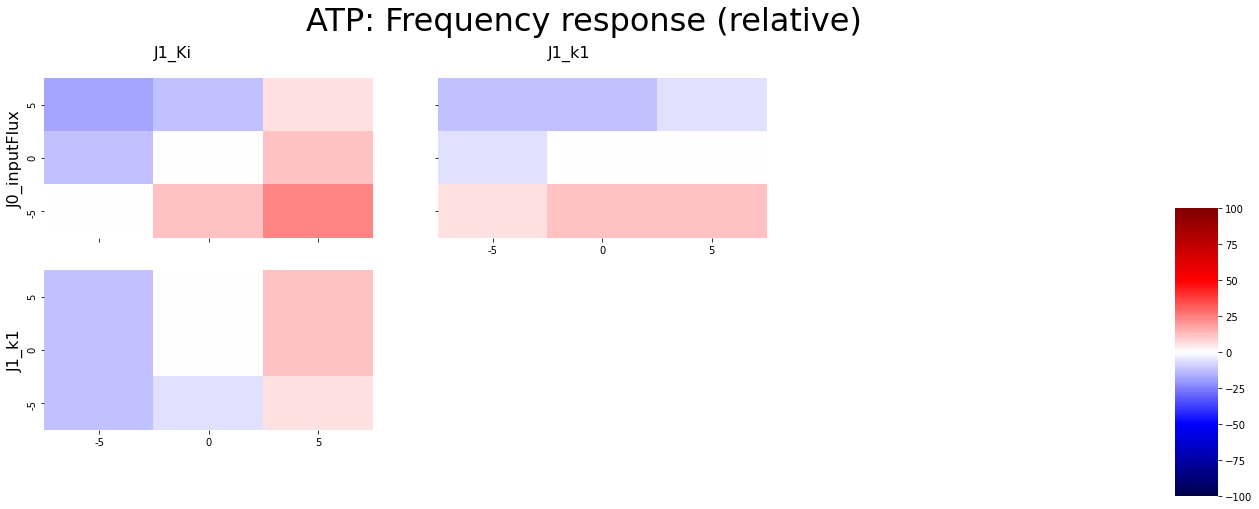

In [13]:
def runStudyTFC(molecule, parameters, percents, isRelative=True, isFrequency=True, figsize=(20, 10)):
    """
    Creates an upper triangular plot of the interactions between parameter pairs in combinations.
    
    Parameters
    ----------
    molecule: str
    parameters: list-str
    percents: list-int
    isRelative: bool
       Results are percent change w.r.t. base
    isFrequency: bool
       Results are for frequencies
    figisze: tuple-int
       Size of figures
    """
    numParameter = len(parameters)
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(numParameter, numParameter)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])
    for rowIdx in range(numParameter):
        parmRowidx = rowIdx
        for colIdx in range(numParameter-rowIdx-1):
            parmColidx = numParameter - colIdx - 1
            frequencyDF, amplitudeDF = runExperimentsTwoParameters(
                parameters[parmRowidx], parameters[parmColidx], 
                percents, percents, isRelative=isRelative)
            if isFrequency:
                responseDF = frequencyDF
            else:
                responseDF = amplitudeDF
            ax = plt.subplot(gs[rowIdx, colIdx])
            # Label the parameters for each column
            if rowIdx == 0:
                ax.text(1, -0.4, parameters[parmColidx], fontsize=util_doe1.FONTSIZE)
            # Only display colorbar for the last plot
            if (rowIdx == numParameter - 2):
                _ = makeHeatmap(responseDF, molecule, ax=ax, isColorbar=True, cbar_ax=cbar_ax)
            else:
                _ = makeHeatmap(responseDF, molecule, ax=ax, isColorbar=False)
            ax.set_xlabel("")
            # Only display ylabel for left-most plot
            if colIdx == 0:
                ax.set_ylabel(parameters[parmRowidx], fontsize=util_doe1.FONTSIZE)
            else:
                ax.set_ylabel("")
                ax.set_yticklabels([])
            # Only show x-tics for bottom-most plot
            if colIdx != (numParameter - rowIdx - 2):
                ax.set_xticklabels([])
    if isFrequency:
        responseType = "Frequency"
    else:
        responseType = "Amplitude"
    if isRelative:
        metricType = "relative"
    else:
        metricType = "absolute"
    suptitle = "%s: %s response (%s)" % (molecule, responseType, metricType)
    plt.suptitle(suptitle, fontsize=2*util_doe1.FONTSIZE)

# Smoke test
runStudyTFC("ATP", wm.WOLF_PRMS[0:3], [-5, 0, 5], isRelative=True, isFrequency=True)    

## Question
1. Analyze realtive frequencies for Glucose.

## Solution

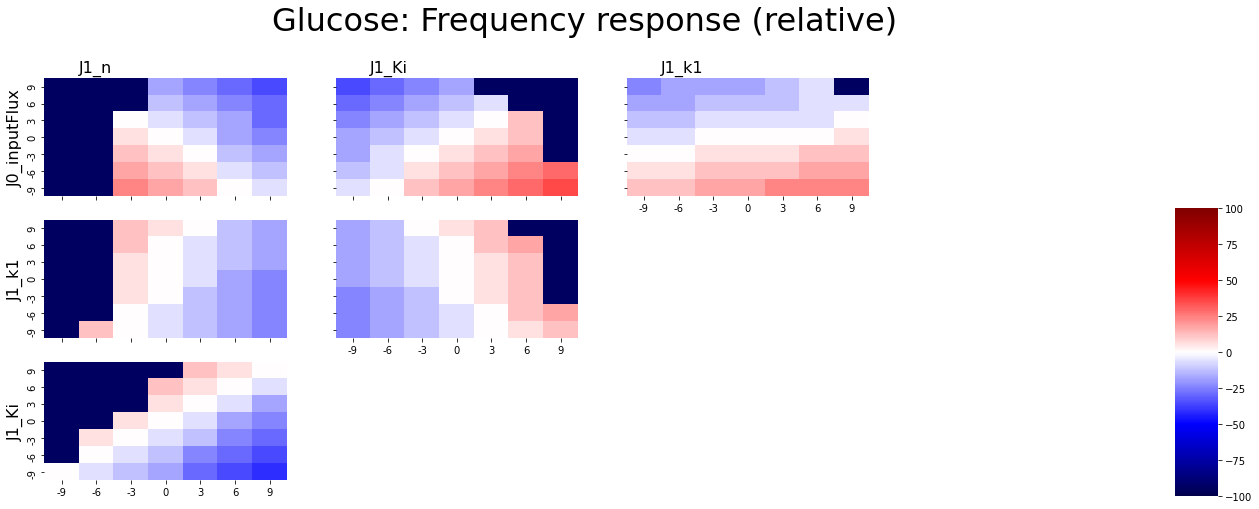

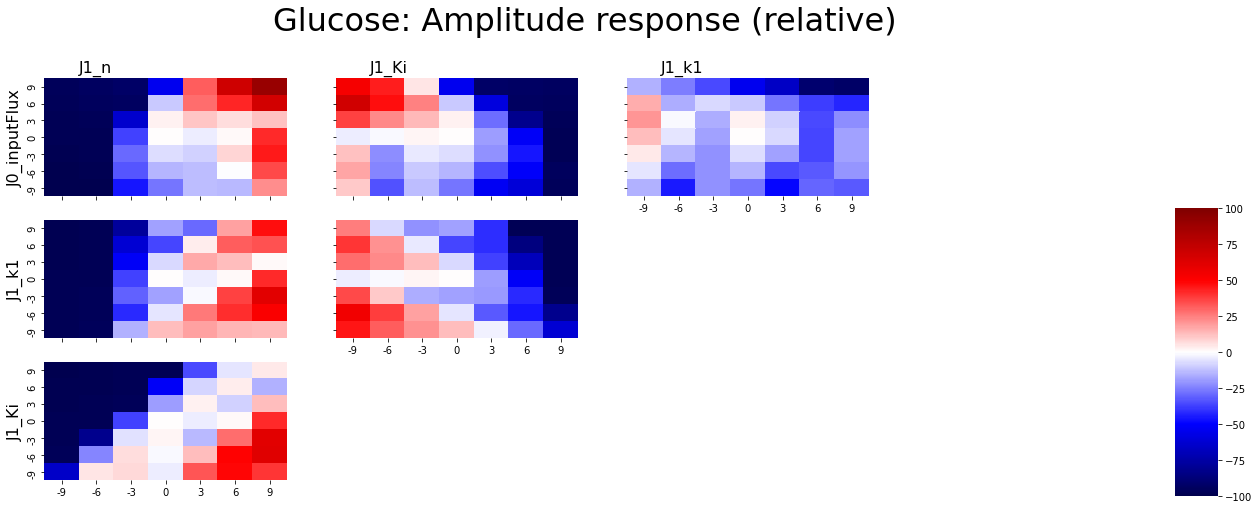

In [14]:
# Analysis for frequency with relative (precentage) responses
percents = 3*(np.array(range(7)) - 3)
for molecule in wm.WOLF_MOL[0:1]:
    for isFrequency in [True, False]:
        runStudyTFC(molecule, wm.WOLF_PRMS[0:4], percents, isRelative=True, isFrequency=isFrequency)    

## Question
1. Which combination of parameters for which response suggest a strong interaction between parameter pairs?# Analysis for frequency with relative (precentage) responses